In [1]:
import datetime
import pandas as pd
from pymongo import MongoClient
from zeep import Client
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**1). Запросить курсы любой валюты за указанный период. Сохранить полученные данные в базу данных Mongo**

**2). Написать функцию, которая принимает в качестве параметров две даты, ищет самую большую разницу между курсами валюты за указанный период и возвращает эти дни.**

**3). Сделать вывод информативным: Валюту <Валюта> выгодно было купить <Дата>, а продать <Дата>. Прибыль: <Разница в цене валюты>**

In [2]:
wsdl = 'http://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL'
zeep_client = Client(wsdl)

In [3]:
currency_name = 'Австралийский доллар'

In [4]:
currencies = zeep_client.service.EnumValutes(Seld=False)

In [5]:
for currency in currencies._value_1._value_1:
    for _, currency_info in currency.items():
        if currency_name in currency_info['Vname']:
            currency_code = currency_info['Vcode']

In [6]:
from_date = datetime.date(2018, 5, 10)
to_date = datetime.date(2019, 8, 15)

In [7]:
dynamics = zeep_client.service.GetCursDynamic(from_date, to_date, currency_code)

In [8]:
df = pd.DataFrame(columns=['date', 'rate'])

for date in dynamics._value_1._value_1:
    for _, date_info in date.items():
        rate_info = {'date': date_info['CursDate'],
                     'rate': date_info['Vcurs']}
        df = df.append(rate_info, ignore_index=True)

In [9]:
df['date'] = pd.to_datetime(df['date'], utc=True)
df['rate'] = df['rate'].astype(float)

df.set_index('date', inplace=True)

Поиск самой выгодной разницы курса:
    - проходим по всем датам (это индекс i);
    - ищем максимальный пик курса в будущем (rate_peak)
    - считаем разницу между между rate_peak и текущим курсом (rate_now).
Нам нужно найти и зафиксровать самую большую положительную разницу - как искомую выгоду.

In [10]:
income, max_income = 0., 0.
for i in df.index:
    rate_now = df['rate'].loc[i]
    
    mask = df.index >= i
    rate_peak = df.loc[mask, 'rate'].max()
 
    income = rate_peak - rate_now
    if income > max_income:
        max_income = income
        rate_min = rate_now
        rate_idxmin = i
        rate_max = rate_peak
        rate_idxmax = df.loc[mask, 'rate'].idxmax()

In [11]:
def date2str(date):
    return '{}.{}.{}'.format(date.day, date.month, date.year)

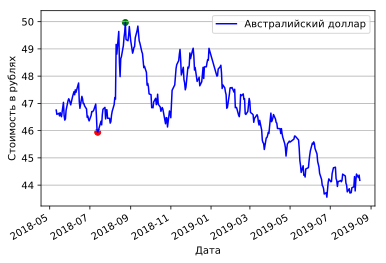

Австралийский доллар выгодно было купить 12.7.2018, а продать 23.8.2018.
Прибыль: 4.0 руб.


In [12]:
df['rate'].plot(c='b', label=currency_name)
plt.scatter(rate_idxmin, rate_min, c='r')
plt.scatter(rate_idxmax, rate_max, c='g')
plt.xlabel('Дата')
plt.ylabel('Стоимость в рублях')
plt.grid(axis='y')
plt.legend(loc='best')
plt.show()

date_min = date2str(rate_idxmin)
date_max = date2str(rate_idxmax)

print('{} выгодно было купить {}, а продать {}.\nПрибыль: {:.2} руб.'.format( \
      currency_name, date_min, date_max, rate_max - rate_min))

Добавляем данные в БД:

In [13]:
mongo_client = MongoClient('mongodb://127.0.0.1:27017')

In [14]:
db = mongo_client['rates']
docs = db.docs

In [15]:
from_str = date2str(from_date)
to_str = date2str(to_date)

In [16]:
db_info = {'from_date': from_str,
           'to_date': to_str,
           'rate': list(df['rate'])}

In [17]:
is_rate_in = docs.find_one({"from_date": from_str,
                            "to_date": to_str})
if is_rate_in == None:
    result = docs.insert_one(db_info)

Проверка:

In [18]:
results = docs.find({"from_date": from_str,
                     "to_date": to_str})
for r in results:
    print(r)

{'_id': ObjectId('5d5fa909f690cb2f4d2ad4fa'), 'from_date': '10.5.2018', 'to_date': '15.8.2019', 'rate': [46.7546, 46.5979, 46.6351, 46.5426, 46.6589, 46.564, 46.5113, 47.0371, 46.5522, 46.3868, 46.4313, 46.7489, 47.1018, 47.1694, 47.1205, 47.0351, 46.9466, 47.2642, 47.3482, 47.4287, 47.3175, 47.4961, 47.4057, 47.7476, 47.0743, 46.8195, 47.2573, 47.1671, 46.9942, 46.9985, 46.9111, 46.7968, 46.4903, 46.5375, 46.4176, 46.3582, 46.5527, 46.7002, 46.6929, 46.7178, 46.7542, 46.9745, 46.5709, 46.0146, 45.9393, 46.0037, 46.2684, 46.3456, 46.2131, 46.5828, 46.7849, 46.8533, 46.4313, 46.7639, 46.7634, 46.4549, 46.4513, 46.2759, 46.3312, 46.569, 46.7092, 46.9564, 47.2184, 47.1557, 49.164, 48.809, 49.6393, 48.4964, 47.9841, 48.638, 48.7123, 49.1225, 49.4298, 49.6168, 49.9691, 49.3451, 49.3004, 49.5055, 49.8209, 49.5638, 49.3256, 48.8436, 48.9249, 49.0536, 49.0789, 49.4038, 49.6905, 49.8358, 49.5567, 49.2951, 49.2181, 48.8964, 48.8288, 48.5754, 48.3122, 48.3623, 48.1376, 47.67, 47.7341, 47.6122, 47

In [19]:
# mongo_client.drop_database('rates')